In [1]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')

In [2]:
from src import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置主题色和ggplot模版
PingFang = FontProperties(fname='../assets/PingFang.ttc')
plt.style.use('ggplot')
plt_color = ["#6A9A8B", "#00754B"]

In [3]:
yelp = pd.read_csv('../data/Yelp_final.csv', encoding='utf-8')

yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112117 entries, 0 to 1112116
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1112117 non-null  object
 1   review_id    1112117 non-null  object
 2   business_id  1112117 non-null  object
 3   stars        1112117 non-null  int64 
 4   type         1112117 non-null  object
 5   city         1112117 non-null  object
 6   categories   1112117 non-null  object
dtypes: int64(1), object(6)
memory usage: 59.4+ MB


# 1 过滤出位于Phoenix的餐厅评论

In [4]:
yelp_reviews = yelp[(yelp.city == 'Phoenix') &
                    (yelp.categories.str.contains('.Restaurant.', case=False))]
# 打印Phoenix餐厅评论的行列数
print("Phoenix餐厅评论的行列数:", yelp_reviews.shape)

Phoenix餐厅评论的行列数: (114865, 7)


获取Phoenix餐厅评论的数据

In [5]:
sparse_matrix_20 = get_sparse_matrix(get_clean_df(
    yelp_reviews,
    min_user_review=20,
    cols=['user_id', 'business_id', 'stars']))

sparse_matrix_30 = get_sparse_matrix(get_clean_df(
    yelp_reviews,
    min_user_review=30,
    cols=['user_id', 'business_id', 'stars']))

计算Phoenix餐厅评论数据的稀疏度

In [6]:
print("用户至少有20条评论的稀疏度:", get_sparsity(sparse_matrix_20))
print("用户至少有20条评论的矩阵形状:", sparse_matrix_20.shape)

用户至少有20条评论的稀疏度: 0.9802353624590376
用户至少有20条评论的矩阵形状: (773, 2129)


In [7]:
print("用户至少有30条评论的稀疏度:", get_sparsity(sparse_matrix_30))
print("用户至少有30条评论的矩阵形状:", sparse_matrix_30.shape)

用户至少有30条评论的稀疏度: 0.971961831146816
用户至少有30条评论的矩阵形状: (424, 2048)


每位用户至少有10条评论的数据

In [8]:
reviews_min_10 = get_clean_df(yelp_reviews,
                              min_user_review=10,
                              cols=['user_id', 'business_id', 'stars'])
print("Phoenix餐厅评论数:", reviews_min_10.shape[0])

Phoenix餐厅评论数: 48818


唯一餐厅数和唯一用户数

In [9]:
print("Phoenix唯一餐厅数 =", len(reviews_min_10.business_id.unique()))
print("Phoenix唯一用户数 =", len(reviews_min_10.user_id.unique()))

Phoenix唯一餐厅数 = 2227
Phoenix唯一用户数 = 2015


In [10]:
# 获取Phoenix餐厅的稀疏矩阵
ratings_sparse_matrix = get_sparse_matrix(reviews_min_10)
print("Phoenix餐厅评分矩阵的形状 =", ratings_sparse_matrix.shape)

Phoenix餐厅评分矩阵的形状 = (2015, 2227)


In [11]:
# 计算Phoenix餐厅评分矩阵的稀疏度
sparsity_phoenix = 1 - ratings_sparse_matrix.nnz / \
    (ratings_sparse_matrix.shape[0] * ratings_sparse_matrix.shape[1])
print("Phoenix餐厅评分矩阵的稀疏度 =", sparsity_phoenix)

Phoenix餐厅评分矩阵的稀疏度 = 0.9891211067420926


In [12]:
# 处理Phoenix餐厅评分矩阵
train_matrix, val_matrix, test_matrix = train_val_test_split(
    ratings_sparse_matrix)
print("Phoenix 训练集形状:", train_matrix.shape)
print("Phoenix 验证集形状:", val_matrix.shape)
print("Phoenix 测试集形状:", test_matrix.shape)

c:\Users\Earth\anaconda3\envs\DataWarehouse-ENV\lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Phoenix 训练集形状: (2015, 2227)
Phoenix 验证集形状: (2015, 2227)
Phoenix 测试集形状: (2015, 2227)


In [13]:
# 将稀疏矩阵划分为训练集、验证集和测试集
# 将包含至少20条评论的Phoenix用户数据划分
train_matrix_users, val_matrix_users, test_matrix_users = train_val_test_split(
    sparse_matrix_20,
    num_review_val=7,
    num_review_test=3
)

print("Phoenix 用户训练集形状:", train_matrix_users.shape)
print("Phoenix 用户验证集形状:", val_matrix_users.shape)
print("Phoenix 用户测试集形状:", test_matrix_users.shape)

Phoenix 用户训练集形状: (773, 2129)
Phoenix 用户验证集形状: (773, 2129)
Phoenix 用户测试集形状: (773, 2129)


# 2 模型构建:

## 2.1 奇异值分解SVD

In [14]:
# 对Phoenix餐厅的训练集矩阵进行SVD分解
# SVD分解将矩阵分解为三个子矩阵 U、S 和 Vt
U_Restaurant, S_Restaurant, Vt_Restaurant = np.linalg.svd(
    train_matrix.todense())

# 打印最小和最大的奇异值
print("最小的奇异值 =", min(S_Restaurant))
print("最大的奇异值 =", max(S_Restaurant))

# 将奇异值对角化，创建对角矩阵
S_phx_res_dia = np.diag(S_Restaurant)

最小的奇异值 = 0.002911892717661976
最大的奇异值 = 223.89964710272758


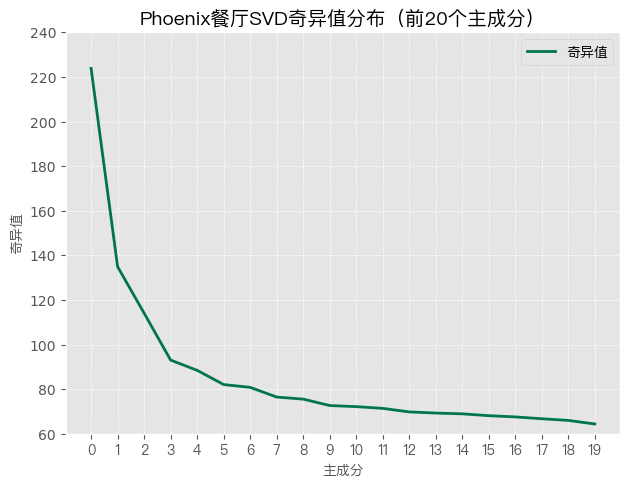

In [15]:
# 绘制凤凰城前20个奇异值
plt.plot(S_Restaurant[:20], '-', linewidth=2,
         color=plt_color[1], label='奇异值')

plt.xticks(np.arange(0, len(S_Restaurant[:20]), 1), fontproperties=PingFang)

plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(60, 240)

plt.legend(prop=PingFang)
plt.ylabel('奇异值', fontproperties=PingFang)
plt.xlabel('主成分', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/01_SVD奇异值分布_前20个主成分.png', dpi=600)
plt.title('Phoenix餐厅SVD奇异值分布（前20个主成分）', fontproperties=PingFang, fontsize=14)
plt.show()

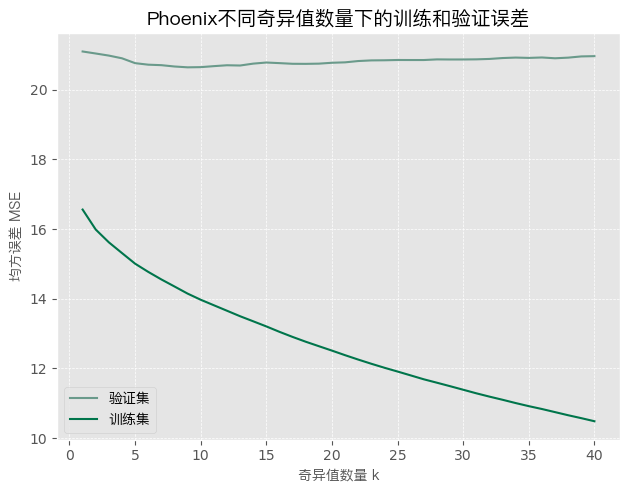

In [16]:
num_singular_values_range = np.arange(1, 41, 1)
validation_errors = {}
training_errors = {}

# 计算训练集和验证集在不同奇异值数量下的误差
for num_singular_values in num_singular_values_range:
    validation_errors[num_singular_values] = compute_approximation_error(
        num_singular_values, val_matrix.todense(), U_Restaurant, S_phx_res_dia, Vt_Restaurant)
    training_errors[num_singular_values] = compute_approximation_error(
        num_singular_values, train_matrix.todense(), U_Restaurant, S_phx_res_dia, Vt_Restaurant)

# 绘制误差图
plt.plot(validation_errors.keys(), validation_errors.values(),
         label='验证集', color=plt_color[0])
plt.plot(training_errors.keys(), training_errors.values(),
         label='训练集', color=plt_color[1])
plt.xlabel('奇异值数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(prop=PingFang, loc='lower left')

plt.tight_layout()
plt.savefig('../images/Phoenix/02_不同奇异值数量下的训练集和验证集误差.png', dpi=600)
plt.title('Phoenix不同奇异值数量下的训练和验证误差', fontproperties=PingFang, fontsize=14)
plt.show()

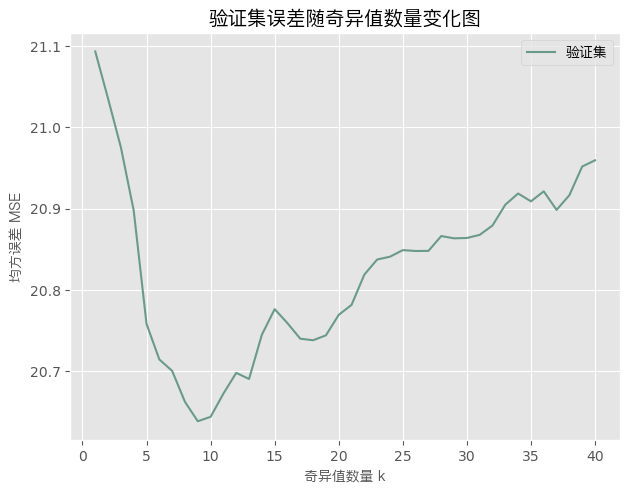

In [17]:
# 分别绘制验证集误差
plt.plot(validation_errors.keys(), validation_errors.values(),
         label='验证集', color=plt_color[0])

# 设置坐标轴标签和图例
plt.xlabel('奇异值数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)

plt.tight_layout()
plt.savefig('../images/Phoenix/03_不同奇异值数量下验证集误差.png', dpi=600)
plt.title('验证集误差随奇异值数量变化图', fontproperties=PingFang, fontsize=14)
# 显示图像
plt.show()

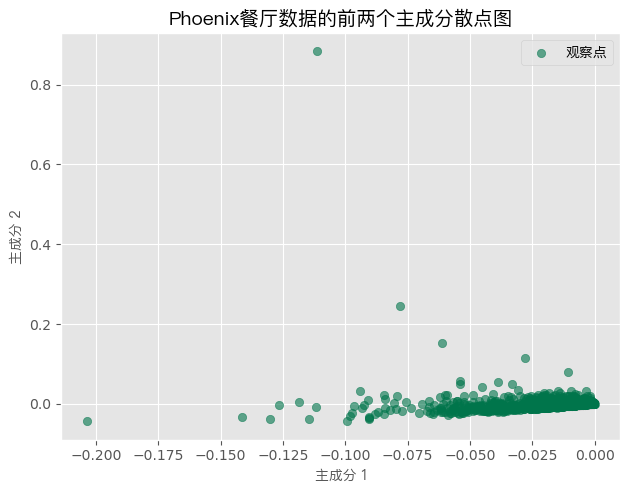

In [18]:
# 使用SVD结果中的前两个主成分绘制散点图
plt.scatter(np.ravel(U_Restaurant[:, 0]), np.ravel(
    U_Restaurant[:, 1]), label='观察点', color=plt_color[1], alpha=0.6)

plt.xlabel('主成分 1', fontproperties=PingFang)
plt.ylabel('主成分 2', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/04_前两个主成分散点图.png', dpi=600)

# 设置标题
plt.title('Phoenix餐厅数据的前两个主成分散点图', fontproperties=PingFang, fontsize=14)
# 显示图像
plt.show()

计算SVD的最佳验证MSE

计算在使用前10个奇异值进行近似重构时，Phoenix餐厅数据在验证集上的最佳均方误差 MSE

In [19]:
best_val_mse_svd = compute_approximation_error(
    num_singular_values=10,
    original_matrix=val_matrix.todense(),
    U=U_Restaurant,
    S=S_phx_res_dia,
    Vt=Vt_Restaurant)

print('Phoenix餐厅使用SVD的最佳验证集均方误差 MSE = ', best_val_mse_svd)

Phoenix餐厅使用SVD的最佳验证集均方误差 MSE =  20.64426298924214


获取Phoenix餐厅训练集、验证集和测试集中非零元素的索引

In [20]:
# 训练集非零元素的索引
train_nonzero_indices = train_matrix.nonzero()

# 验证集非零元素的索引
val_nonzero_indices = val_matrix.nonzero()

# 测试集非零元素的索引
test_nonzero_indices = test_matrix.nonzero()

In [21]:
# 使用前10个奇异值进行SVD重构，计算重构后的矩阵
reconstructed_matrix_svd = np.dot(U_Restaurant[:, :10], np.dot(
    S_phx_res_dia[:10, :10], Vt_Restaurant[:10, :]))

# 获取训练集、验证集和测试集在重构矩阵中的预测值
train_predictions_svd = np.ravel(
    reconstructed_matrix_svd[train_nonzero_indices])
val_predictions_svd = np.ravel(
    reconstructed_matrix_svd[val_nonzero_indices])
test_predictions_svd = np.ravel(
    reconstructed_matrix_svd[test_nonzero_indices])

## 2.2 带偏差校正的SVD

In [22]:
# 计算Phoenix餐厅训练矩阵的全局偏差
global_bias = np.sum(train_matrix) / train_matrix.nnz

# 去除全局偏差后的训练矩阵
train_matrix_wo_bias = train_matrix.todense() - global_bias

# 对去除偏差后的训练矩阵进行SVD分解
U_phx_wo_bias, S_phx_wo_bias, Vt_phx_wo_bias = np.linalg.svd(
    train_matrix_wo_bias)

# 打印最小和最大的奇异值
print("最小的奇异值 =", min(S_phx_wo_bias))
print("最大的奇异值 =", max(S_phx_wo_bias))

# 将奇异值对角化，创建对角矩阵
S_phx_diag_wo_bias = np.diag(S_phx_wo_bias)

最小的奇异值 = 0.0029359522954777147
最大的奇异值 = 8386.078521439107


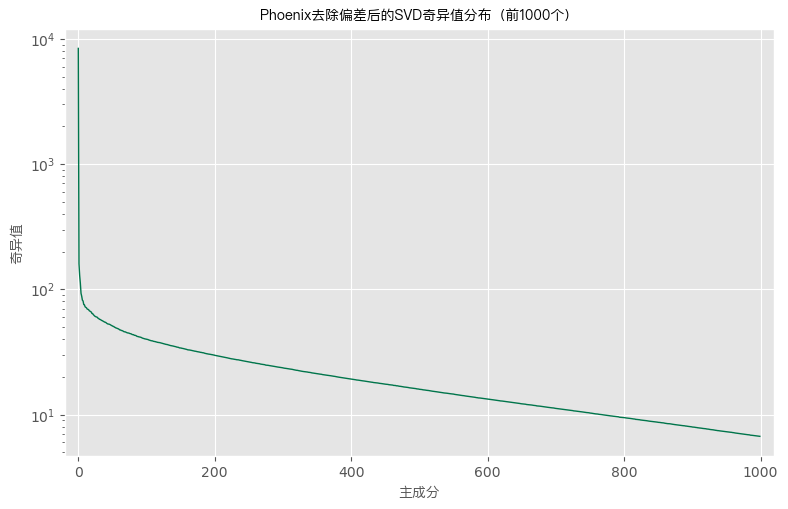

In [23]:
# 绘制前1000个奇异值的Elbow图
fig = plt.figure(figsize=(8, 5))
plt.semilogy(S_phx_wo_bias[:1000], '-', linewidth=1, color=plt_color[1])
plt.xlim(-20, 1020)
plt.xlabel('主成分', fontproperties=PingFang)
plt.ylabel('奇异值', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/05_去除偏差后的SVD_奇异值分布（前1000个）.png', dpi=600)
plt.title('Phoenix去除偏差后的SVD奇异值分布（前1000个）', fontproperties=PingFang)
plt.show()

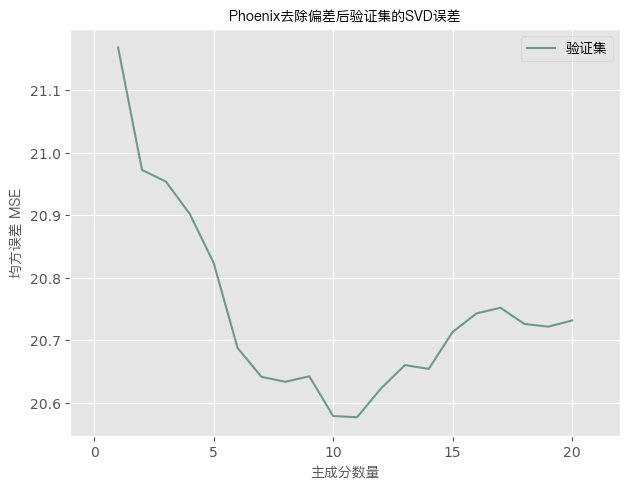

In [24]:
# 计算去除偏差后的SVD误差
k_wo_bias = np.arange(1, 21)
errors_svd_wo_bias = {}
sm_u_10_phx_res_val_wo_bias = val_matrix.todense() - global_bias

for i in k_wo_bias:
    sm_u_10_phx_res_val_wo_bias_rec = np.dot(U_phx_wo_bias[:, :i], np.dot(
        S_phx_diag_wo_bias[:i, :i], Vt_phx_wo_bias[:i, :]))
    idx_wo_bias = np.where(val_matrix.todense() > 0)
    diff_wo_bias = sm_u_10_phx_res_val_wo_bias[idx_wo_bias] - \
        sm_u_10_phx_res_val_wo_bias_rec[idx_wo_bias]
    errors_svd_wo_bias[i] = np.linalg.norm(
        diff_wo_bias)**2 / diff_wo_bias.shape[1]

# 绘制误差图
plt.plot(errors_svd_wo_bias.keys(),
         errors_svd_wo_bias.values(), color=plt_color[0],
         label='验证集')
plt.xlim(-1, 22)
plt.xlabel('主成分数量', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/06_去除偏差后SVD_验证集重构误差.png', dpi=600)
plt.title('Phoenix去除偏差后验证集的SVD误差', fontproperties=PingFang)
plt.show()

In [25]:
# 计算Phoenix训练矩阵的用户和物品偏差，并去除偏差
user_bias_phx, item_bias_phx, train_matrix_no_bias_phx = compute_global_user_item_bias(
    train_matrix)

In [26]:
# 对去除偏差后的Phoenix训练矩阵进行SVD分解
U_phx_no_bias, S_phx_no_bias, Vt_phx_no_bias = np.linalg.svd(
    train_matrix_no_bias_phx)
print("最小的奇异值 =", min(S_phx_no_bias))
print("最大的奇异值 =", max(S_phx_no_bias))
S_phx_diag_no_bias = np.diag(S_phx_no_bias)

最小的奇异值 = 0.0029219365426626496
最大的奇异值 = 16260.238983459323


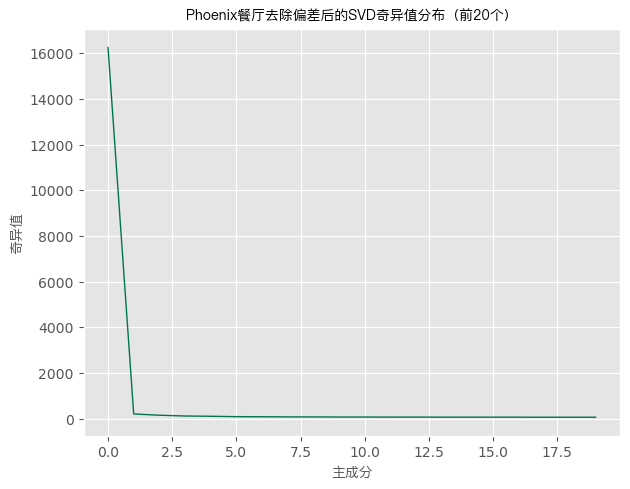

In [27]:
plt.plot(S_phx_no_bias[:20], '-', linewidth=1, color=plt_color[1])

plt.xlabel('主成分', fontproperties=PingFang)
plt.ylabel('奇异值', fontproperties=PingFang)

plt.tight_layout()
plt.savefig('../images/Phoenix/07_去除偏差后的SVD_奇异值分布.png', dpi=600)
plt.title('Phoenix餐厅去除偏差后的SVD奇异值分布（前20个）', fontproperties=PingFang)
plt.show()

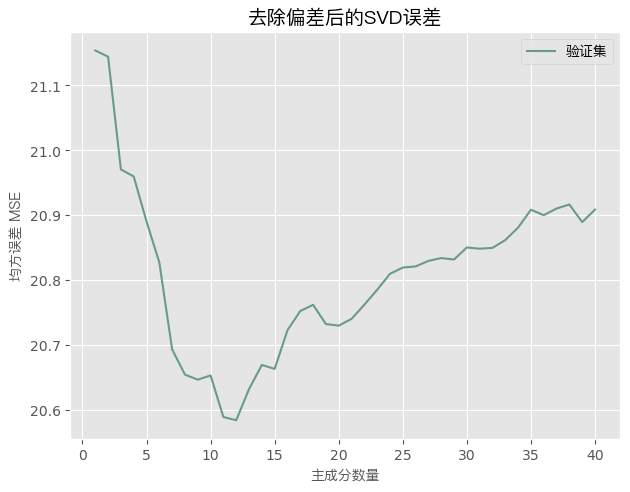

In [28]:
num_components_wo_bias = np.arange(1, 41, 1)
errors_svd_no_bias = {}
val_matrix_no_bias_phx = val_matrix.todense() - user_bias_phx - \
    item_bias_phx
# 计算去除偏差后的SVD误差
for test_features in num_components_wo_bias:
    reconstructed_val_matrix_no_bias = np.dot(U_phx_no_bias[:, :test_features], np.dot(
        S_phx_diag_no_bias[:test_features, :test_features], Vt_phx_no_bias[:test_features, :]))
    non_zero_indices_no_bias = np.where(val_matrix.todense() > 0)
    diff_no_bias = val_matrix_no_bias_phx[non_zero_indices_no_bias] - \
        reconstructed_val_matrix_no_bias[non_zero_indices_no_bias]
    errors_svd_no_bias[test_features] = np.linalg.norm(
        diff_no_bias)**2 / diff_no_bias.shape[1]

# 绘制去除偏差后的SVD误差图
plt.plot(errors_svd_no_bias.keys(), errors_svd_no_bias.values(),
         label='验证集', color=plt_color[0])
plt.xlabel('主成分数量', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/08_去除偏差后的SVD_验证集重构误差.png', dpi=600)
plt.title('去除偏差后的SVD误差', fontproperties=PingFang, fontsize=14)
plt.show()

## 2.3 修正偏差的余弦相似度

In [29]:
# 计算餐厅相似度矩阵
similarity_matrix_restaurant = compute_similarity_matrix(
    train_matrix,
    axis='res')
similarity_matrix_restaurant = np.array(similarity_matrix_restaurant)

# 预测餐厅相似度的评分
preds_cosine_phx = predict_top_k(
    np.array(train_matrix.todense()),
    similarity_matrix_restaurant,
    kind='res',
    k=1)

# 计算餐厅相似度的均方误差
MSE_cosine_res = calculate_mse(
    preds_cosine_phx,
    np.array(val_matrix.todense()))
print("餐厅间余弦相似度的MSE =", MSE_cosine_res)

餐厅间余弦相似度的MSE = 22.411061285500747


In [30]:
# 计算用户相似度矩阵
simi_phx_users = compute_similarity_matrix(train_matrix, axis='users')
simi_phx_users = np.array(simi_phx_users)

# 预测用户相似度的评分
preds_cosine_phx_users = predict_top_k(
    np.array(train_matrix.todense()), simi_phx_users, kind='user', k=1)

# 计算用户相似度的均方误差
MSE_cosine_users = calculate_mse(
    preds_cosine_phx_users, np.array(val_matrix.todense()))
print("用户间余弦相似度的MSE =", MSE_cosine_users)

用户间余弦相似度的MSE = 22.411061285500747


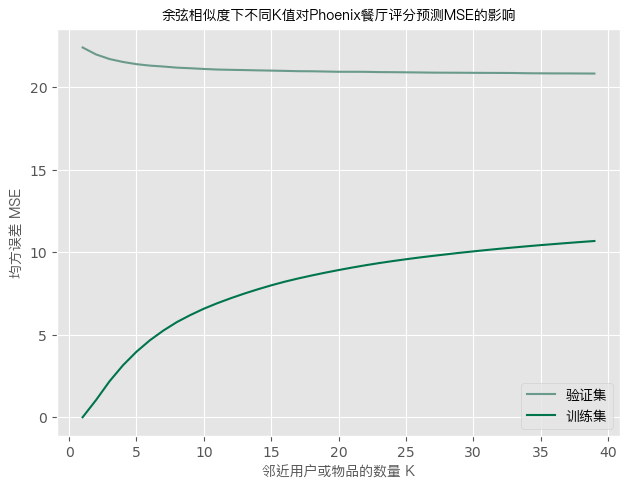

In [31]:
# 定义空字典存储不同K值下的验证集和训练集误差
errors_cs_res_phx_val = {}
errors_cs_res_phx_train = {}

# 定义K值的范围
k_cs = np.arange(1, 40)

# 遍历每个K值，计算预测的均方误差（MSE）
for i in k_cs:
    # 使用余弦相似性对Phoenix餐厅的评分数据进行预测
    preds_cs_res_phx = predict_top_k(
        np.array(train_matrix.todense()), similarity_matrix_restaurant, kind='res', k=i)

    # 计算验证集和训练集的均方误差
    error_cs_val = calculate_mse(
        preds_cs_res_phx, np.array(val_matrix.todense()))
    error_cs_train = calculate_mse(
        preds_cs_res_phx, np.array(train_matrix.todense()))

    # 将计算结果存储到字典中
    errors_cs_res_phx_val[i] = error_cs_val
    errors_cs_res_phx_train[i] = error_cs_train

# 绘制K值与均方误差的关系图
plt.plot(errors_cs_res_phx_val.keys(),
         errors_cs_res_phx_val.values(), label='验证集', color=plt_color[0])
plt.plot(errors_cs_res_phx_train.keys(),
         errors_cs_res_phx_train.values(), label='训练集', color=plt_color[1])


plt.xlabel('邻近用户或物品的数量 K', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/09_余弦相似度模型_不同K值对评分预测MSE的影响.png', dpi=600)
plt.title('余弦相似度下不同K值对Phoenix餐厅评分预测MSE的影响', fontproperties=PingFang)

plt.show()

使用余弦相似度和最优K值40对Phoenix餐厅的评分数据进行预测

In [32]:
preds_cosine_phx = predict_top_k(
    np.array(train_matrix.todense()), similarity_matrix_restaurant, kind='res', k=40)

# 计算使用余弦相似度得到的预测结果在验证集上的均方误差 (MSE)
Best_Val_MSE_Cosine_phx = calculate_mse(
    preds_cosine_phx, np.array(val_matrix.todense()))

# 打印余弦相似度在Phoenix餐厅验证集上的最佳MSE结果
print('Phoenix餐厅余弦相似性模型在K=40时的最佳验证集MSE为 = ',
      Best_Val_MSE_Cosine_phx)

Phoenix餐厅余弦相似性模型在K=40时的最佳验证集MSE为 =  20.829829402698582


In [33]:
train_prediction_cos = preds_cosine_phx[train_nonzero_indices]
val_prediction_cos = preds_cosine_phx[val_nonzero_indices]
test_prediction_cos = preds_cosine_phx[test_nonzero_indices]

## 2.4 交替最小二乘法ALS

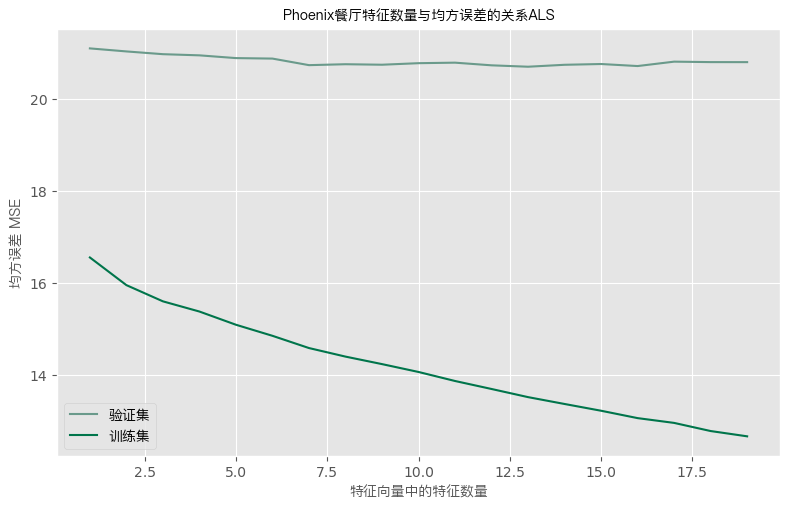

In [34]:
# 初始化不同的特征数量和存储误差的列表
num_features = np.arange(1, 20, 1)
test_error_als = []
train_error_als = []

# 遍历不同的特征数量
for i in num_features:
    # 使用交替最小二乘法（ALS）进行预测
    preds_als = als(np.array(train_matrix.todense()),
                    num_features=i, iterations=5)

    # 计算验证集和训练集的均方误差
    test_err = calculate_mse(preds_als, np.array(val_matrix.todense()))
    train_err = calculate_mse(
        preds_als, np.array(train_matrix.todense()))

    # 将误差添加到列表中
    test_error_als.append(test_err)
    train_error_als.append(train_err)

# 创建图表并设置大小
fig = plt.figure(figsize=(8, 5))

# 绘制特征数量与均方误差的关系
plt.plot(num_features, test_error_als, label='验证集', color=plt_color[0])
plt.plot(num_features, train_error_als, label='训练集', color=plt_color[1])


plt.xlabel('特征向量中的特征数量', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/10_ALS_特征数量与均方误差的关系.png', dpi=600)
plt.title('Phoenix餐厅特征数量与均方误差的关系ALS', fontproperties=PingFang)
plt.show()

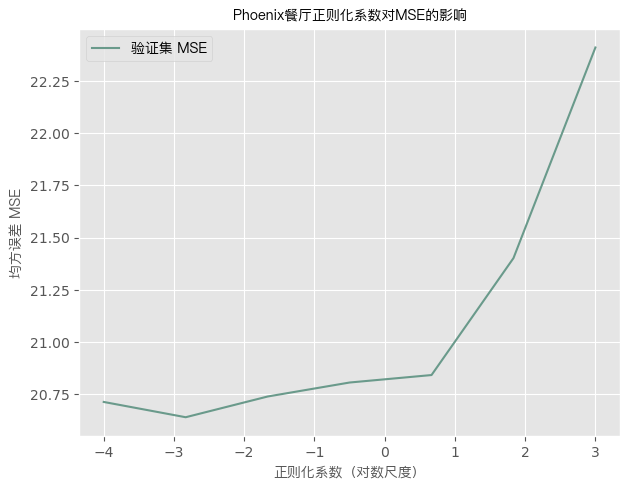

In [35]:
user_reg = np.logspace(-4, 3, 7)
val_error_als = {}  # 初始化存储验证集误差的字典

# 遍历不同的正则化参数
for i in user_reg:
    # 初始化当前正则化参数下的验证集误差列表
    val_error_als[i] = []

    # 使用ALS算法进行预测，同时应用相同的正则化参数于用户和物品
    preds_als = als(np.array(train_matrix.todense()), num_features=10,
                    iterations=5, user_regularization=i, item_regularization=i)

    # 计算并存储验证集的均方误差
    val_err = calculate_mse(preds_als, np.array(val_matrix.todense()))
    val_error_als[i].append(val_err)

# 绘制正则化参数（对数尺度）与MSE的关系图
plt.plot(np.log10(user_reg), [
         errors[0] for errors in val_error_als.values()], label='验证集 MSE', color=plt_color[0])


plt.xlabel('正则化系数（对数尺度）', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/11_ALS_正则化系数对MSE的影响.png', dpi=600)
plt.title('Phoenix餐厅正则化系数对MSE的影响', fontproperties=PingFang)
plt.show()

In [36]:
# 调用ALS函数，设置特征数量为10，迭代次数为5，以及用户和物品的正则化参数均为0.001
preds_als_phx = als(ratings_matrix=np.array(train_matrix.todense()),
                    num_features=10,
                    iterations=5,
                    user_regularization=0.001,
                    item_regularization=0.001)

# 使用calculate_mse函数计算验证集的均方误差
Best_Val_MSE_als_phx = calculate_mse(
    preds_als_phx,
    np.array(val_matrix.todense()))

# 打印验证集的最佳均方误差
print('Phoenix餐厅ALS模型的最佳验证均方误差为：', Best_Val_MSE_als_phx)

Phoenix餐厅ALS模型的最佳验证均方误差为： 20.754969351792756


In [37]:
train_prediction_als = preds_als_phx[train_nonzero_indices]
val_prediction_als = preds_als_phx[val_nonzero_indices]
test_prediction_als = preds_als_phx[test_nonzero_indices]

## 2.5 带偏差修正的随机梯度下降

当前迭代次数 =  10
当前迭代次数 =  11
当前迭代次数 =  12
当前迭代次数 =  13
当前迭代次数 =  14
当前迭代次数 =  15
当前迭代次数 =  16
当前迭代次数 =  17
当前迭代次数 =  18
当前迭代次数 =  19
当前迭代次数 =  20
当前迭代次数 =  21
当前迭代次数 =  22
当前迭代次数 =  23
当前迭代次数 =  24
当前迭代次数 =  25
当前迭代次数 =  26
当前迭代次数 =  27
当前迭代次数 =  28
当前迭代次数 =  29
当前迭代次数 =  30
当前迭代次数 =  31
当前迭代次数 =  32
当前迭代次数 =  33
当前迭代次数 =  34
当前迭代次数 =  35
当前迭代次数 =  36
当前迭代次数 =  37
当前迭代次数 =  38
当前迭代次数 =  39
当前迭代次数 =  40
当前迭代次数 =  41
当前迭代次数 =  42
当前迭代次数 =  43
当前迭代次数 =  44
当前迭代次数 =  45
当前迭代次数 =  46
当前迭代次数 =  47
当前迭代次数 =  48
当前迭代次数 =  49
当前迭代次数 =  50


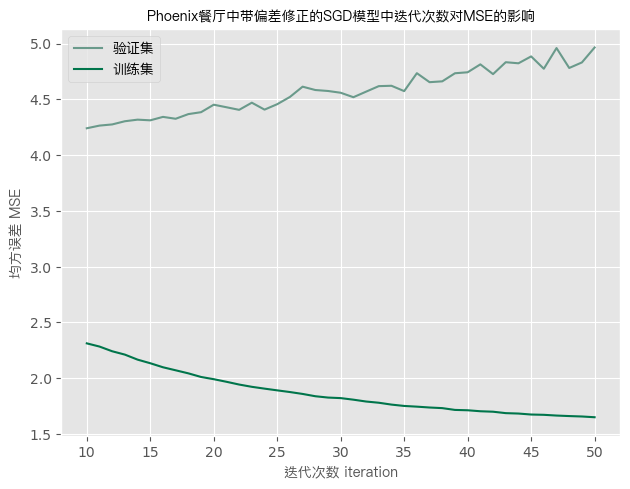

In [38]:
iters = np.arange(10, 51, 1)
err_sgd_test = []  # 存储验证集的错误率
err_sgd_train = []  # 存储训练集的错误率

# 遍历不同的迭代次数，需要调整 Iters 超参数
for i in iters:
    print('当前迭代次数 = ', i)

    # 使用带偏差校正的SGD进行模型训练
    prediction_sgd_with_bias = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=10, iterations=i)

    # 计算验证集和训练集的均方误差
    err_test = calculate_mse(
        prediction_sgd_with_bias[0], np.array(val_matrix.todense()))
    err_train = calculate_mse(
        prediction_sgd_with_bias[0], np.array(train_matrix.todense()))

    # 将结果添加到列表中
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)


# 绘制迭代次数与MSE的关系图
plt.plot(iters, err_sgd_test, label='验证集', color=plt_color[0])
plt.plot(iters, err_sgd_train, label='训练集', color=plt_color[1])

plt.xlabel('迭代次数 iteration', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/12_带偏差修正的SGD_MSE与迭代次数的关系.png', dpi=600)
plt.title('Phoenix餐厅中带偏差修正的SGD模型中迭代次数对MSE的影响', fontproperties=PingFang)

plt.show()

可以设置我们的最佳迭代次数 = 20

当前特征数量 k =  1
当前特征数量 k =  2
当前特征数量 k =  3
当前特征数量 k =  4
当前特征数量 k =  5
当前特征数量 k =  6
当前特征数量 k =  7
当前特征数量 k =  8
当前特征数量 k =  9
当前特征数量 k =  10
当前特征数量 k =  11
当前特征数量 k =  12
当前特征数量 k =  13
当前特征数量 k =  14
当前特征数量 k =  15


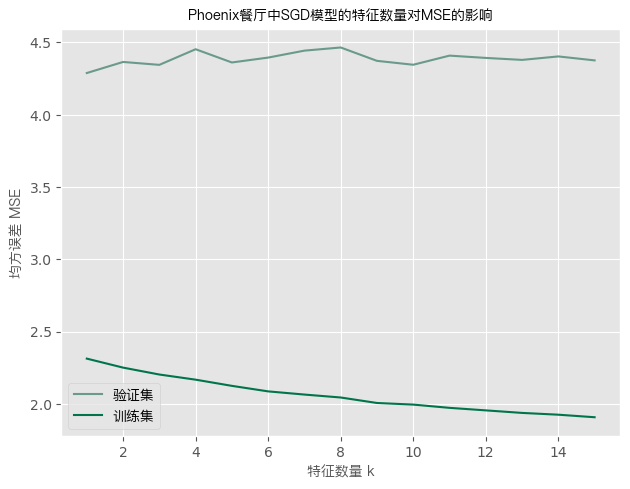

In [39]:
# 定义特征数量的范围
test_features = np.arange(1, 16, 1)
err_sgd_test = []  # 存储验证集的误差
err_sgd_train = []  # 存储训练集的误差

# 遍历不同的特征数量
for i in test_features:
    print('当前特征数量 k = ', i)

    # 使用带偏差校正的SGD进行模型训练
    prediction_sgd_with_bias = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=i, iterations=20)

    # 计算验证集和训续练集的均方误差
    err_test = calculate_mse(
        prediction_sgd_with_bias[0], np.array(val_matrix.todense()))
    err_train = calculate_mse(
        prediction_sgd_with_bias[0], np.array(train_matrix.todense()))

    # 将结果添加到列表中
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)

# 绘制特征数量与MSE的关系图
plt.plot(test_features, err_sgd_test,  label='验证集', color=plt_color[0])
plt.plot(test_features, err_sgd_train, label='训练集', color=plt_color[1])

# 设置图表的标题和坐标轴标签

plt.xlabel('特征数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Phoenix/13_带偏差修正的SGD_特征数量与MSE关系.png', dpi=600)
plt.title('Phoenix餐厅中SGD模型的特征数量对MSE的影响', fontproperties=PingFang)
plt.show()

可以设置我们的最佳特征数量 k 值 = 2

In [40]:
# 使用带偏己校正的SGD算法训练模型，并获取预测结果、误差数组、用户向量和资源向量
# 设置特征数量为2，迭代次数为20
predictions_sgd, error_array_sgd, user_vec_sgd, res_vec_sgd = sgd_with_bias_correction(
    np.array(train_matrix.todense()),
    num_features=2, iterations=20)

In [41]:
# 重新调用SGD函数，以确保获得预测结果
prediction_sgd_with_bias = sgd_with_bias_correction(
    np.array(train_matrix.todense()), num_features=2, iterations=20)

# 计算验证集的均方误差
Best_Val_MSE_sgd_phx = calculate_mse(
    prediction_sgd_with_bias[0], np.array(val_matrix.todense()))

# 打印验证集上的最佳均方误差
print('Phoenix餐厅SGD模型的最佳验证均方误差为：', Best_Val_MSE_sgd_phx)

Phoenix餐厅SGD模型的最佳验证均方误差为： 4.273837045369687


In [42]:
# 使用预测结果对训练集、验证集和测试集的非零索引位置进行评分预测
train_prediction_sgd = prediction_sgd_with_bias[0][train_nonzero_indices]
val_prediction_sgd = prediction_sgd_with_bias[0][val_nonzero_indices]
test_prediction_sgd = prediction_sgd_with_bias[0][test_nonzero_indices]

## 2.6 随机森林Random Forest
将矩阵补全问题转换为回归问题

随机森林回归器尝试学习用户潜在向量和餐厅潜在向量之间的非线性依赖关系。目标变量是用户i对餐厅j的评分。本质上它归结为一个回归问题。

将矩阵补全问题转换为回归问题的核心思想是利用用户和物品（餐厅）的特征向量来预测评分。矩阵补全问题的目标是填补评分矩阵中的缺失值，即预测用户尚未评分的物品（餐厅）评分。通过将问题转换为回归问题，我们可以利用特征向量（隐因子）来建立模型，从而实现评分预测。

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=5)

# 拼接用户和物品特征向量，用于训练、验证和测试
train_phx = concatenate_user_item_vectors(
    user_vec_sgd, res_vec_sgd, train_matrix)
val_phx = concatenate_user_item_vectors(
    user_vec_sgd, res_vec_sgd, val_matrix)
test_phx = concatenate_user_item_vectors(
    user_vec_sgd, res_vec_sgd, test_matrix)

In [44]:
# 将拼接后的向量转换为numpy数组
train_mat_phx = np.array(train_phx)
val_mat_phx = np.array(val_phx)
test_mat_phx = np.array(test_phx)
x_train, y_train = train_mat_phx[:, :-1], np.ravel(train_mat_phx[:, -1])
x_val, y_val = val_mat_phx[:, :-1], np.ravel(val_mat_phx[:, -1])

In [45]:
rf.fit(train_mat_phx[:, :4], train_mat_phx[:, 4])
preds_rf_phx = rf.predict(val_mat_phx[:, :4]).reshape(-1, 1)
MSE_rf_phx = calculate_mse(preds_rf_phx, val_mat_phx[:, 4])
print('随机森林分类器的均方误差 =', MSE_rf_phx)

随机森林分类器的均方误差 = 4.5186534592079415


In [46]:
train_prediction_rf = rf.predict(train_mat_phx[:, :4])
val_prediction_rf = rf.predict(val_mat_phx[:, :4])
test_prediction_rf = rf.predict(test_mat_phx[:, :4])

# 3 评估
## 所有预测模型的集合（SVD，余弦模型，ALS，SGD，RF）

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
# 构建包含训练集预测结果的DataFrame
ensemble_training_df = build_ensemble_dataframe(
    svd_predictions=train_predictions_svd,   # SVD模型的训练集预测结果
    cosine_predictions=train_prediction_cos,  # 余弦相似性模型的训练集预测结果
    als_predictions=train_prediction_als,    # ALS模型的训练集预测结果
    sgd_predictions=train_prediction_sgd,    # SGD模型的训练集预测结果
    rf_predictions=train_prediction_rf       # 随机森林模型的训练集预测结果
)

# 构建包含验证集预测结果的DataFrame
ensemble_validation_df = build_ensemble_dataframe(
    svd_predictions=val_predictions_svd,     # SVD模型的验证集预测结果
    cosine_predictions=val_prediction_cos,   # 余弦相似性模型的验证集预测结果
    als_predictions=val_prediction_als,      # ALS模型的验证集预测结果
    sgd_predictions=val_prediction_sgd,      # SGD模型的验证集预测结果
    rf_predictions=val_prediction_rf         # 随机森林模型的验证集预测结果
)

# 构建包含测试集预测结果的DataFrame
ensemble_testing_df = build_ensemble_dataframe(
    svd_predictions=test_predictions_svd,    # SVD模型的测试集预测结果
    cosine_predictions=test_prediction_cos,  # 余弦相似性模型的测试集预测结果
    als_predictions=test_prediction_als,     # ALS模型的测试集预测结果
    sgd_predictions=test_prediction_sgd,     # SGD模型的测试集预测结果
    rf_predictions=test_prediction_rf        # 随机森林模型的测试集预测结果
)

In [49]:
y_train_phx = np.ravel(
    np.array(train_matrix[train_nonzero_indices]))
y_val_phx = np.ravel(np.array(val_matrix[val_nonzero_indices]))
y_test_phx = np.ravel(np.array(test_matrix[test_nonzero_indices]))

In [50]:
lr_phx = LinearRegression(fit_intercept=True)
lr_phx.fit(ensemble_training_df.iloc[:, -3:], y_train_phx)
ensemble_val_pred_phx = lr_phx.predict(ensemble_validation_df.iloc[:, -3:])
MSE_ensemble_phx = calculate_mse(ensemble_val_pred_phx, y_val_phx)
print('模型集的均方误差 =', MSE_ensemble_phx)

模型集的均方误差 = 4.413641895478811


高惩罚的岭回归

In [51]:
from sklearn.linear_model import Ridge
lrr_phx = Ridge(alpha=10000)
lrr_phx.fit(ensemble_training_df.iloc[:, -3:], y_train_phx)
ensemble_val_pred_phx = lrr_phx.predict(
    ensemble_validation_df.iloc[:, -3:])
MSE_ensemble_phx = calculate_mse(ensemble_val_pred_phx, y_val_phx)
print('模型集成在验证集的均方误差=', MSE_ensemble_phx)

模型集成在验证集的均方误差= 4.3114383156053835


在测试数据上测试最佳模型并检查测试准确性**最佳模型是集成模型。**

In [52]:
ensemble_test_pred_phx = lrr_phx.predict(ensemble_testing_df.iloc[:, -3:])
MSE_test_phx = calculate_mse(ensemble_test_pred_phx, y_test_phx)
print('模型集成在测试集均方误差=', MSE_test_phx)

模型集成在测试集均方误差= 4.498087304950667
